In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


# Installing and importing required libraries

In [2]:
!pip install dmba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 72.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from dmba import regressionSummary
import matplotlib.pylab as plt
%matplotlib inline

no display found. Using non-interactive Agg backend


# Data Import and Cleanup

**Importing all the datasets**

In [4]:
train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
print(train_df.shape)
train_df.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
shops_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
print(shops_df.shape)
shops_df.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
items_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
print(items_df.shape)
items_df.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_categories_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
print(item_categories_df.shape)
item_categories_df.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
print(test_df.shape)
test_df.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


**Checking all the datasets for Null values**

In [9]:
print(train_df.isnull().sum())
print()
print(shops_df.isnull().sum())
print()
print(items_df.isnull().sum())
print()
print(item_categories_df.isnull().sum())
print()
print(test_df.isnull().sum())
print()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

shop_name    0
shop_id      0
dtype: int64

item_name           0
item_id             0
item_category_id    0
dtype: int64

item_category_name    0
item_category_id      0
dtype: int64

ID         0
shop_id    0
item_id    0
dtype: int64



**Combining all the datasets to create a combined data frame.**

In [10]:
combined_df = pd.merge(train_df, shops_df, on = ['shop_id'], how = 'left')
combined_df = pd.merge(combined_df, items_df, on = ['item_id'], how = 'left')
combined_df = pd.merge(combined_df, item_categories_df, on = ['item_category_id'], how = 'left')
combined_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
...,...,...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,"Москва ТРК ""Атриум""",V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства
2935845,09.10.2015,33,25,7460,299.00,1.0,"Москва ТРК ""Атриум""",V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства
2935846,14.10.2015,33,25,7459,349.00,1.0,"Москва ТРК ""Атриум""",V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства
2935847,22.10.2015,33,25,7440,299.00,1.0,"Москва ТРК ""Атриум""",V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3


# EDA

**Checking the number unique shops and items**

In [11]:
cols = []
u_recs = []

u_dblocks = len(pd.unique(combined_df['date_block_num']))
cols.append('date_block_num')
u_recs.append(u_dblocks)

u_shopids = len(pd.unique(combined_df['shop_id']))
cols.append('shop_id')
u_recs.append(u_shopids)

u_itemids = len(pd.unique(combined_df['item_id']))
cols.append('item_id')
u_recs.append(u_itemids)

u_recs_per_col = pd.DataFrame({
    'Column': cols,
    'Unique_Records': u_recs
})
u_recs_per_col

,Column,Unique_Records
0,date_block_num,34
1,shop_id,60
2,item_id,21807


**Checking the overall sales trend**

<AxesSubplot:>

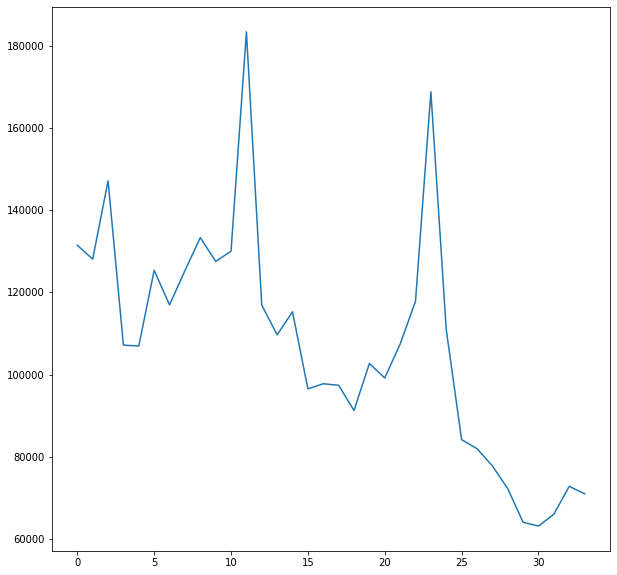

In [12]:
overall_trend = combined_df[['date_block_num','item_cnt_day']].groupby(['date_block_num']).sum().reset_index()
overall_trend.item_cnt_day.plot.line(figsize=(10,10))

Based on above the graph we can see that there is a downward sales trend which means sales are decreasing overtime since last 10 months or so.

**Checking the sales trend across shops**

<AxesSubplot:>

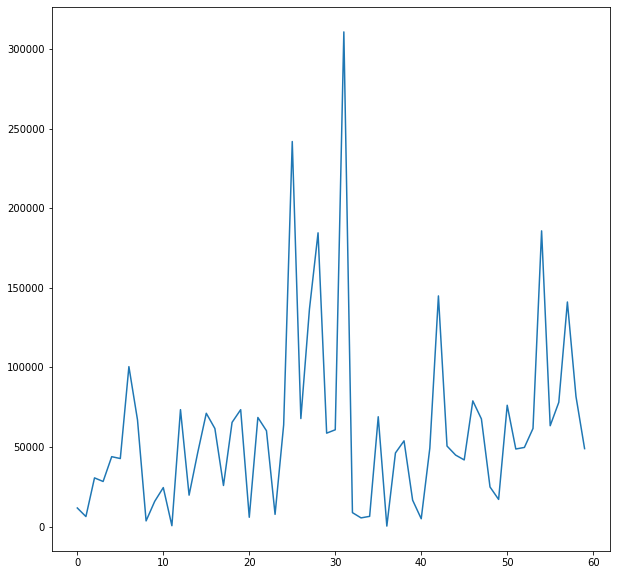

In [13]:
trend_by_shop = combined_df[['shop_id','item_cnt_day']].groupby(['shop_id']).sum().reset_index()
trend_by_shop.item_cnt_day.plot.line(figsize=(10,10))

Based on above graph we can see that there are only couple of shops with very high sales as compared to other shops.

**Checking the sales trend across items**

<AxesSubplot:>

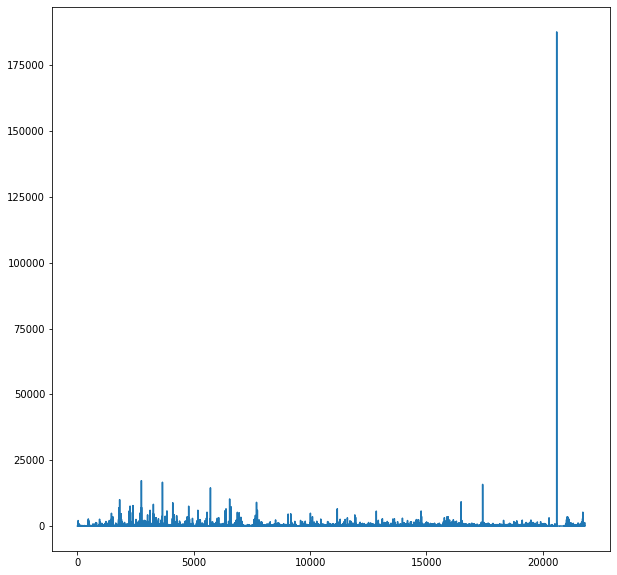

In [14]:
trend_by_item = combined_df[['item_id','item_cnt_day']].groupby(['item_id']).sum().reset_index()
trend_by_item.item_cnt_day.plot.line(figsize=(10,10))

Based on above graph we can see that the sales for one perticular item is very high as compared to all other items.

**Checking the sales data for seasonality**

In [15]:
combined_df['date'] = pd.to_datetime(combined_df['date'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:>

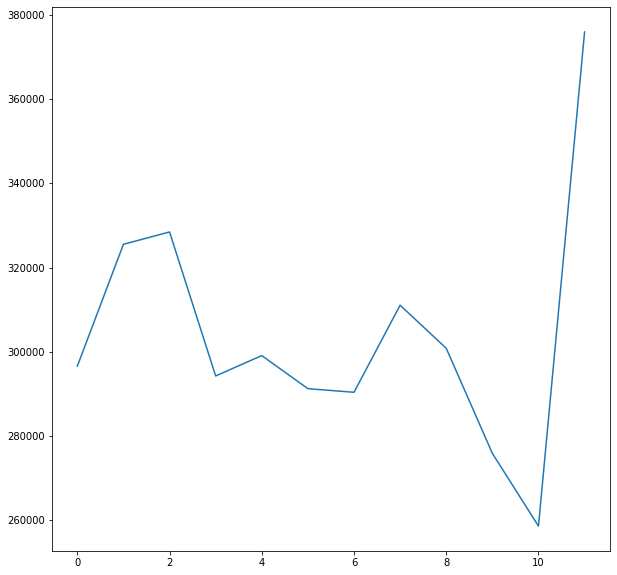

In [16]:
seasonality = combined_df[['date','item_cnt_day']]
seasonality['month'] = seasonality['date'].dt.month
seasonality = seasonality[['month','item_cnt_day']].groupby(['month']).sum().reset_index()
seasonality.item_cnt_day.plot.line(figsize=(10,10))

Based on above graph we can see that sales are impacted by the season, which means sales are very high towards the year end (Nov, Dec) as compared to other months of the year.

# Data Pre-Processing

**Coverting the training dataset to show monthly sales for shop-item combination.**

In [17]:
monthly_sales_data = combined_df[['date_block_num','shop_id','item_id','item_cnt_day']].groupby(['date_block_num','shop_id','item_id']).sum().reset_index()
monthly_sales_data = monthly_sales_data.pivot_table(index=['shop_id','item_id'],columns='date_block_num',values='item_cnt_day',fill_value=0).reset_index()
monthly_sales_data.columns.name = 'Id'
monthly_sales_data

Id,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424119,59,22154,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424120,59,22155,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
424121,59,22162,0,0,0,0,0,0,0,0,...,0,9,4,1,1,0,0,1,0,0
424122,59,22164,0,0,0,0,0,0,0,0,...,0,2,1,2,0,0,1,0,0,0


Since this is a time series analytics problem we have to consider the sales data available from last 34 months (Jan-2013 to Oct-2015) all the shop-item combinations for which we are interested to predict the future sales (Nov-2015)
So we need to use the training data (historical data) for those shop-item combinations from test data.

In [18]:
df_to_predict = pd.merge(test_df, monthly_sales_data, on = ['item_id', 'shop_id'], how = 'left')
df_to_predict

,ID,shop_id,item_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,214196,45,16188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214197,214197,45,15757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,214198,45,19648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Checking for which shop-item combinations we have historical data and for which we don't.
The shop-item combinations for which we dont have historical data we will use the average sales for that shop to impute the null values. (this is an approximation we need for predicting the future sales when we dont have historical time series data for that specific shop-item combination)

In [19]:
df_tp1 = df_to_predict.dropna().reset_index()
df_tp1.drop(['index'],axis=1,inplace=True)
df_tp1

,ID,shop_id,item_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
2,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,5,5,5039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0
4,6,5,5041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111399,214192,45,4352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111400,214193,45,18049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
111401,214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
111402,214197,45,15757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_tp2 = df_to_predict[df_to_predict.isna().any(axis=1)].reset_index()
df_tp2.drop(['index'],axis=1,inplace=True)
df_tp2

,ID,shop_id,item_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,5,5003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16,5,4874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,5,5002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102791,214188,45,9500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102792,214189,45,16007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102793,214194,45,18027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102794,214196,45,16188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
avg_by_shop = combined_df[['shop_id','item_cnt_day']].groupby(['shop_id']).mean().reset_index()
avg_by_shop

,shop_id,item_cnt_day
0,0,1.187481
1,1,1.111483
2,2,1.178100
3,3,1.110567
4,4,1.149051
5,5,1.120040
6,6,1.215647
7,7,1.154659
8,8,1.053634
9,9,4.229805


In [22]:
def impute_avg(sid):
    return int(avg_by_shop.item_cnt_day[avg_by_shop.shop_id == sid])

In [23]:
sales_col = list(range(3,37))
for c in sales_col:
    df_tp2.iloc[:,c] = df_tp2.apply(lambda row : impute_avg(row['shop_id']), axis = 1)

In [24]:
df_to_predict = df_tp1.append(df_tp2, ignore_index=True)
df_to_predict

,ID,shop_id,item_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
2,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,5,5,5039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0
4,6,5,5041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214188,45,9500,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
214196,214189,45,16007,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
214197,214194,45,18027,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
214198,214196,45,16188,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Naive Regressor.

Building a navie classifier just based on historical average monthly sales for available shop-item combination and using that to predict the future sales for shop-item combinations given in test dataset.
This is a naive approach since we are not considering the trend and seasonality effect on the sales of a perticular item at perticular shop.In other words we are not using the time series data here, but instead just using historical sales data to get the average sales for each shop-item combination.Also we are training the model based on average sales of some shop-item combination and then trying to predict future sales for some other shop-item combinations.
So ther accuracy for this type of model will be considerably low.

**Getting average monthly sales**

In [25]:
monthly_sales_data['avg_sales'] = monthly_sales_data.iloc[:,3:36].mean(axis=1)
monthly_sales_data

Id,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,avg_sales
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.939394
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.333333
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.303030
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.090909
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.424242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424119,59,22154,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
424120,59,22155,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.030303
424121,59,22162,0,0,0,0,0,0,0,0,...,9,4,1,1,0,0,1,0,0,0.484848
424122,59,22164,0,0,0,0,0,0,0,0,...,2,1,2,0,0,1,0,0,0,0.181818


**Defining independent and dependent variables (predictors, outcome)**

In [26]:
nr_x = monthly_sales_data[['shop_id','item_id']]
nr_y = monthly_sales_data[['avg_sales']]

In [27]:
nr_x

Id,shop_id,item_id
0,0,30
1,0,31
2,0,32
3,0,33
4,0,35
...,...,...
424119,59,22154
424120,59,22155
424121,59,22162
424122,59,22164


In [28]:
nr_y

Id,avg_sales
0,0.939394
1,0.333333
2,0.303030
3,0.090909
4,0.424242
...,...
424119,0.000000
424120,0.030303
424121,0.484848
424122,0.181818


**Spliting data into train and validation set**

In [29]:
nr_train_x, nr_valid_x, nr_train_y, nr_valid_y = train_test_split(nr_x, nr_y, test_size=0.2, random_state=1)

**Training naive regression model**

In [30]:
naive_regressor = LinearRegression()
naive_regressor.fit(nr_train_x, nr_train_y)


print('Naive Regression Model to predict future sales')
print()
print('Intercept: ', np.round(naive_regressor.intercept_, 2))
print(pd.DataFrame({'Predictor': nr_x.columns, 'Coefficient': np.round(naive_regressor.coef_[0],5)}))

Naive Regression Model to predict future sales

Intercept:  [0.29]
  Predictor  Coefficient
0   shop_id      0.00130
1   item_id     -0.00001


**Using naive regressor to make predictions for validation set**

In [31]:
nr_pred_sales_val = naive_regressor.predict(nr_valid_x)
p = nr_pred_sales_val.flatten()
a = nr_valid_y.values.flatten()
print('Result of naive regressor')
nr_result = round(pd.DataFrame({'Actual': a,'Predicted': p, 'Residual': a - p}), 2)
print(nr_result)

Result of naive regressor
       Actual  Predicted  Residual
0        0.15       0.21     -0.05
1        0.03       0.28     -0.25
2        0.03       0.30     -0.27
3        0.03       0.31     -0.28
4        0.24       0.28     -0.04
...       ...        ...       ...
84820    0.82       0.29      0.53
84821    0.27       0.36     -0.09
84822    0.03       0.22     -0.19
84823    1.21       0.28      0.93
84824    0.30       0.23      0.07

[84825 rows x 3 columns]


**Checking the performance and accuracy measures for the naive regressor**

These performance and accuracy measures are not giving us the correct picutre of the accuracy of the forcasting since the model is not utilizing time series data efficiently and there can be data leakage since we are spliting the training and vaidation sets randomly.

In [32]:
r2 = round(r2_score(a, p),3)
print('r2 : ', r2)
print()
print('Accuracy Measures for validation')
regressionSummary(a, p)
print()
nr_pred_sales_train = naive_regressor.predict(nr_train_x)
tp = nr_pred_sales_train.flatten()
ta = nr_train_y.values.flatten()
print('Accuracy Measures for training')
regressionSummary(ta, tp)

r2 :  0.002

Accuracy Measures for validation

Regression statistics

               Mean Error (ME) : -0.0115
Root Mean Squared Error (RMSE) : 1.2320
     Mean Absolute Error (MAE) : 0.2641

Accuracy Measures for training

Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 2.0909
     Mean Absolute Error (MAE) : 0.2754


since there is not much difference in the accuracy measures for the training and validation sets. We can say there is no model over fitting here.

**Using naive regressor to make predictions of future sales for test set**

In [33]:
test_in = test_df[['shop_id','item_id']]
future_sales =  naive_regressor.predict(test_in)
test_out = test_df[['shop_id','item_id']]
test_out['future_sales'] = future_sales.flatten()
test_out

,shop_id,item_id,future_sales
0,5,5037,0.262891
1,5,5320,0.260960
2,5,5233,0.261554
3,5,5232,0.261561
4,5,5268,0.261315
...,...,...,...
214195,45,18454,0.223531
214196,45,16188,0.238991
214197,45,15757,0.241932
214198,45,19648,0.215384


# Time Series Regressor

In this model we are still using the linear regression but instead of using the average monthly sales to train the model we will use the historical sales data to train the model to predict sales of the next month based on previous month's sales.

Here we are focusing only on the shop-item combinations for which we want to predict the future sales (test dataset) since the sales data for any other shop-item combinations is not directly affecting the sales for a perticular shop-item combination.We are more interested in training the model to learn the sales trend for a perticular shop-item combination over time, and use that to predict the future sales for the same shop-item combination.

To do this we will use 1st 11 months of sales data as independent variables (Xs) and sales data for 12th month will be treated as dependent varibale (Y) to train the model. Next 11 months of data as (Xs) and 24th month of data to validate the model with overlap of 1 month and finally use the last 11 months of data to predict the future sales. 

This model will work better than the naive regressor becasue sales trend, seasonality is being considered here.

In [34]:
time_series_regressor = LinearRegression()
tsr_train_x = df_to_predict.iloc[:,3:14]
tsr_train_y = df_to_predict.iloc[:,14]
time_series_regressor.fit(tsr_train_x, tsr_train_y)

LinearRegression()

In [35]:
tsr_valid_x = df_to_predict.iloc[:,14:25]
tsr_valid_y = df_to_predict.iloc[:,25]

tsr_pred_sales_val = time_series_regressor.predict(tsr_valid_x)
p = tsr_pred_sales_val.flatten()
a = tsr_valid_y.values.flatten()
print('Result of naive regressor')
result = round(pd.DataFrame({'Actual': a,'Predicted': p, 'Residual': a - p}), 2)
print(result)

Result of naive regressor
        Actual  Predicted  Residual
0          1.0       0.45      0.55
1          0.0       0.04     -0.04
2          0.0       0.04     -0.04
3          0.0       0.87     -0.87
4          0.0       0.04     -0.04
...        ...        ...       ...
214195     1.0       1.14     -0.14
214196     1.0       1.14     -0.14
214197     1.0       1.14     -0.14
214198     1.0       1.14     -0.14
214199     1.0       1.14     -0.14

[214200 rows x 3 columns]


In [36]:
r2 = round(r2_score(a, p),3)
print('r2 : ', r2)
print()
print('Accuracy Measures Validation')
regressionSummary(a, p)
print()
tsr_pred_sales_train = time_series_regressor.predict(tsr_train_x)
tp = tsr_pred_sales_train.flatten()
ta = tsr_train_y
print('Accuracy Measures Training')
regressionSummary(ta, tp)

r2 :  0.548

Accuracy Measures Validation

Regression statistics

               Mean Error (ME) : -0.0228
Root Mean Squared Error (RMSE) : 2.8402
     Mean Absolute Error (MAE) : 0.4433

Accuracy Measures Training

Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 2.0625
     Mean Absolute Error (MAE) : 0.3317


In [37]:
test_in = df_to_predict.iloc[:,26:37]
future_sales =  time_series_regressor.predict(test_in)
test_out = df_to_predict[['shop_id','item_id']]
test_out['future_sales'] = future_sales.flatten()
test_out

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,shop_id,item_id,future_sales
0,5,5037,0.566588
1,5,5233,3.056238
2,5,5232,-0.029698
3,5,5039,0.718934
4,5,5041,2.527012
...,...,...,...
214195,45,9500,1.142995
214196,45,16007,1.142995
214197,45,18027,1.142995
214198,45,16188,1.142995
